# 1. Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import data
import skimage
from skimage.filters.thresholding import threshold_li,threshold_local,threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, remove_small_objects, ball
from skimage.morphology import disk
from scipy import ndimage as ndi
import sys,os, glob

#import skimage.filters.median

#import skimage.segmentation as seg
#import skimage.filters as filters
#import skimage.draw as draw
#import skimage.color as color

#from skimage.filters.thresholding import _cross_entropy
#from skimage.morphology import black_tophat, skeletonize, convex_hull_image


#pip install nd2reader_required for nd2 file reading
from nd2reader import ND2Reader

import pandas as pd

In [2]:
import cellpose
from cellpose import models

In [3]:
from tqdm import tqdm

# 2. Define data parameters

In [4]:
# Common parameters for loading the image files of interest

# for 4 channels nd2 images: channel index order is 1-2-3-4, which is the order as ch405-ch488-ch560-ch647


# analysis done
num_of_ch = 3

# Replace protein/dna label name in the "xxx" below for the indicated channel index (make sure the order is correct)
# For example: ch_dict = {"dna":1,"rpa/rpa2":2,"mdc1":3,"pol2S5":4} if rpa/rpa2 was used for ch488
# Make sure the label name is the same as the factor/dna key used in the line below
ch_dict = {"dna":1,"Mdc1":2,"other":3}

# If use mdc1 as the factor for region segementation
# If use dna/dapi as the key channel for nucleus segmentation
mdc1_key =  "Mdc1"
dna_key = 'dna'  # temporary fix since DNA is not good
other_key="other"

# Whether to analyze the sub-area masks defined by the second marker within the first marker (e.g., h2ax within the mdc) 
analyze_ch_for_2nd_marker_dict = {1:True,2:True,3:False}

# Replace the data directory in the ""; * is the final path level where images are located
# For example: data_save_folder = r"F:\XXX\AAA\BBB\*"

# define well here
# candidate wells: 3, 4, 5, 6, 7
#well_name = 'well3' # done
#well_name = 'well4' #done
#well_name = 'well5' #done
#well_name = 'well6' #done
#well_name = 'well7' #done


############################# CHANGE WELL FOR DATA OF INTEREST ABVOE!##########################################

############################# CHANGE WELL FOR DATA OF INTEREST BELOW!##########################################
data_output_folder = r"D:\Analyzed_CellBio\Stam\40x_MNbody_analysis\220623IF_220601exp_p53_control_fixed\220621exp_cov1"
data_main_folder =os.path.join(data_output_folder, '*')
############################# CHANGE WELL FOR DATA OF INTEREST HERE!##########################################



data_input_folder = data_main_folder
data_files = [file for file in glob.glob(data_input_folder) if file[-3:]=="nd2"]

data_files

['D:\\Analyzed_CellBio\\Stam\\40x_MNbody_analysis\\220623IF_220601exp_p53_control_fixed\\220621exp_cov1\\220621 RPE1 p53ko control Mdc1-488 H2AX-568_.nd2',
 'D:\\Analyzed_CellBio\\Stam\\40x_MNbody_analysis\\220623IF_220601exp_p53_control_fixed\\220621exp_cov1\\220621 RPE1 p53ko control Mdc1-488 H2AX-568_001.nd2']

In [5]:
# analyze all ND file or not
# also used as bool setting for adjusting code indendation between different pipelines
_analyze_all_nd = True
#_analyze_all_nd = True

# print progress
_verbose = True

# bad fovs to exclude (e.g., out of focus nd file) if analyze all nd file
# {nd_file_index : [fov_indexes]}
if _analyze_all_nd:
    #fov_to_exclude_dict = {1:[4,5],5:[2,3]}
    fov_to_exclude_dict = {1:[16]}
    

# The pixel size for excluding small 53BP_body;
# Replace *300* with other number desired or *0* if do not want to perform 53BP1 body foci exclusion durng analysis
# Desired foci exclusion can still be performed post-hoc in the resulting dataframe after analysis
# use 200 for 40x images
small_53BP_size = 200

# Other parameteres for image analysis
# border pixel removal for h2ax (or other markers within sub-mdc1 area) positive or less-positive area
h2ax_border_size_filter = 1

# aproximate size for each cell (nuclei)
nuclei_filter = 1000

# for removing tiny nucleoli areas
small_nucleoli_dirt = 10

# erosion factor for dna segmenation
erosion_factor_dna = 5


# std ratio for positive mdc or h2ax, etc calling
h2ax_std_ratio = 3
mdc_std_ratio = 2

# if analyze cell of interest based on annotation:
# the approx distance radius range between the given center and the segmenated center
coord_dist = 100
# if if perform image cropping covering the cell of interest or not
crop_image =  True
raw_image_size = [2048,2048]

# if adjust the focal plane using a smaller crop range than the range used for actual analysis (aka cell size)
narrow_adjust = True
# define the narrowed ratio of the initial crop
narrow_ratio = 0.1


# if re-adjust the focal plane based on cell of interest
adjust_z_for_cell = False


# the cropped image size if performing image cropping covering the cell of interest
cell_size =400

# the percentile for Pol2 to segment the nucleoli area
po2_neg_percentile = 10

# use DAPI channel to do nuclei segmentation or not
use_dna_nuclei = True # shall be good since local dapi in the center is okay

# the alternative channel key if using other channel for nuclei segmentation
if not use_dna_nuclei:
    dna_key = pol2_key
    
    
# specify the region from the whole fov where analysis would be performed
search_xylim = [0,2048]  # Note that DNA channel from the data often is not evenly illuminated


# if save the cropped raw images or not
save_crop_raw_image = True



# 3. Analyze data

In [6]:
# Initiate result dataframe to store analysis measurement:
measurement_for_all_fov_df = pd.DataFrame()


# Initiate cellpose model
model= models.Cellpose(gpu=False, model_type='nuclei',)
####################################################################################
# Loop through each ND data file
for data_ind, data in enumerate(data_files[:]):

    # data name: usually the experiment name 
    data_name = data.split('\\')[-1]

    # if use annotation, then check if data/exp name is in the annotation dict
    if not _analyze_all_nd:
        if data_name in cell_info_dict.keys():
            if _verbose:
                print(f"-----------------------------------------------------------")    
                print(f"-- Start analyzing the dataset of {data_name}")
            # load data if ND data exists in the anntation
            images = ND2Reader(data)
            num_of_planes = images.sizes["z"] # load 'z' info
            # multi-fov image
            if 'v' in images.sizes.keys():
                num_of_fov = images.sizes["v"] # load 'v' info
            # set num_of_fov as 1 for single fov image
            else:
                num_of_fov = 1
        
            # load fov_of_interest from the preprocessed cell_info_dict
            fov_of_interest_str = cell_info_dict[data_name].keys()
            fov_of_interest = [(int(_fov_str)-1) for _fov_str in fov_of_interest_str]
            #print(fov_of_interest)
        else:
            fov_of_interest = []
                    
    # load data without using annotation
    else:
        images = ND2Reader(data)
        num_of_planes = images.sizes["z"] # load 'z' info
        # multi-fov image
        if 'v' in images.sizes.keys():
            num_of_fov = images.sizes["v"] # load 'v' info
        # set num_of_fov as 1 for single fov image
        else:
            num_of_fov = 1
            
        # if exclude bad focal plane that are not focused
        fovs_all = list(range(num_of_fov))
        if data_ind in fov_to_exclude_dict.keys():
            fov_of_interest = [ind for ind in fovs_all if ind not in fov_to_exclude_dict[data_ind]]
        else:
            fov_of_interest = fovs_all
            
###########################################################################################
# Loop through each FOV of interest
    if _verbose:# for indentation purposes
        
        for _fov_id in tqdm(fov_of_interest[:]):                
            
            # use annotation dict to look for cell of interest
            if not _analyze_all_nd:
                if _verbose:
                    print ('-- Use given annotation dict to find cells.')
                cell_coord_list = cell_info_dict[data_name][str(_fov_id+1)] 
            
            # use 3D nuclei signal to do segmenation by cellpose
            else:
                if _verbose:
                    print ('-- Generate 3D nuclei segmentation to find cells.')
                image_cell_3d = []
                for _lyr in range(num_of_planes): # ch index starts from 0
                    image_cell = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[dna_key]-1, z=_lyr))
                    image_cell_3d.append(image_cell)
                image_cell_3d = np.array(image_cell_3d)
                #
                nuclei_mask_3d,flows, styles, diams = model.eval(image_cell_3d, diameter=90, 
                                                    channels = [0,0],
                                                   flow_threshold=1, do_3D=False)
                
                noncell_mask_all = nuclei_mask_3d==0
                
                # remove edge cell
                nuclei_mask_3d=cellpose.utils.remove_edge_masks(nuclei_mask_3d, change_index=True)
                nuclei_mask_3d=cellpose.utils.fill_holes_and_remove_small_masks(nuclei_mask_3d, min_size=nuclei_filter)
                
                mask_save_path = data_output_folder + os.sep + f'segmentations_{mdc_std_ratio}_{small_53BP_size}_crop_subset_controlled' +  os.sep + \
                        f'{data_name}' +os.sep + f'_Pos_{_fov_id+1}'
                if not os.path.exists(mask_save_path):
                    os.makedirs(mask_save_path)
                mask_name = f'Nuclei_segmenations_exclude_edges_Pos_{_fov_id+1}.tif'
                if os.path.exists(mask_save_path+os.sep+mask_name):
                    os.remove(mask_save_path+os.sep+mask_name)
                io.imsave(mask_save_path+os.sep+mask_name,(skimage.img_as_ubyte(nuclei_mask_3d)), check_contrast=False)
                
                #print(num_of_nuclei)
                # if use the cell coord refined analysis
                cell_coord_list  = []
                for i in np.unique(nuclei_mask_3d)[:]:
                    if i >0:
                        # initate dict to store result
                        measurement_each_dict = {}
                        _cell_id=i
                        cand_nucleus = nuclei_mask_3d == i
                        cand_nucleus[cand_nucleus>0]=1
                        cand_nucleus = np.array(cand_nucleus)
                        # append the coord for the objects of interest
                        region = skimage.measure.regionprops (skimage.measure.label(cand_nucleus))[0]
                        # centroid coord as YX, select the cells within the predefined bound
                        check_Y_pos = region.centroid[0] >= search_xylim[0] and region.centroid[0] <= search_xylim[1]
                        check_X_pos = region.centroid[1] >= search_xylim[0] and region.centroid[1] <= search_xylim[1]
                        if check_Y_pos and check_X_pos:
                            cell_center = [int(region.centroid[1]),int(region.centroid[0])]
                            cell_coord_list.append(cell_center)
                            if _verbose:
                                print (f'-- Processing Cell#{_cell_id} from the image')

                            # define as nuclei mask
                            nuclei_to_measure = cand_nucleus
                            noncell_background = noncell_mask_all

                            # Find the best focal plane using the m6T/mdc (the factor key) channel for the cell of interest  
                            #image_fl = []
                            image_std = []
                            image_3d_for_label = []

                            for _lyr in range(num_of_planes): # ch index starts from 0
                                image_array_fl = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[mdc1_key]-1, z=_lyr))                  
                                # do cropping if necessary; remember to inver XY
                                if crop_image: # current crop size as rough cell size
                                    crop_y1 = int(max(0,cell_center[1]-cell_size/2))
                                    crop_y2 = int(min(raw_image_size[1],cell_center[1]+cell_size/2))
                                    crop_x1 = int(max(0,cell_center[0]-cell_size/2))
                                    crop_x2 = int(min(raw_image_size[0],cell_center[0]+cell_size/2))
                                    image_array_fl = image_array_fl[crop_y1:crop_y2,crop_x1:crop_x2]


                                 # use image signal STD distribution to find the best focal plane for the plane of interest
                                _fl=image_array_fl.flatten()
                                image_std.append(np.std(_fl))
                                #also append the image for later potential usage (eg. re-adjust focal plane)
                                #image_3d_for_label.append(image_array_fl)

                            # find the initial best focal plane using std features          
                            best_plane_index = np.argmax(np.array(image_std))
                            if _verbose:
                                print(f"-- Analyzing the plane {best_plane_index+1} in fov {_fov_id+1}.")
                            sel_img = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[mdc1_key]-1, z=best_plane_index))                  

                            if crop_image: # current crop size as rough cell size
                                sel_img = sel_img[crop_y1:crop_y2,crop_x1:crop_x2]
                                nuclei_to_measure = nuclei_to_measure[crop_y1:crop_y2,crop_x1:crop_x2]
                                noncell_background = noncell_background[crop_y1:crop_y2,crop_x1:crop_x2]


                            # Get cellular mdc mask 
                            mdc_intensity = sel_img*nuclei_to_measure
                            mdc_intensity_filtered = mdc_intensity[mdc_intensity!=0]
                            mdc_positive_th =np.mean(mdc_intensity_filtered) + np.std(mdc_intensity_filtered)*mdc_std_ratio
                            mdc_mask = np.logical_and(sel_img>mdc_positive_th, nuclei_to_measure)
                            mdc_chr_mask = remove_small_objects(mdc_mask, small_53BP_size,connectivity=1)
                            mdc_chr_mask = ndi.binary_fill_holes(mdc_chr_mask)
                            mdc_chr_mask = dilation(mdc_chr_mask,disk(1))
                            mdc_chr_mask = erosion(mdc_chr_mask,disk(1))

                            # Append info and results for cells of interest
                            measurement_each_dict['exp_name']=data_input_folder.split('\\')[-2]
                            measurement_each_dict['position_id']=f'{data_name}_Pos{_fov_id+1}'
                            measurement_each_dict['cell_id']=int(_cell_id+1)
                            measurement_each_dict['cell_xyz_coord']=[cell_center, best_plane_index+1]

                            measurement_each_dict['mdc1_size']=np.sum(mdc_chr_mask)
                            measurement_each_dict['nucleus_size']=np.sum(nuclei_to_measure)
                            measurement_each_dict['mdc1_relative_size']=np.sum(mdc_chr_mask)/np.sum(nuclei_to_measure)
                            measurement_each_dict['mdc1_mdc1_intensity']=np.mean((sel_img * mdc_chr_mask)[mdc_chr_mask!=0])
                            measurement_each_dict['nucleus_mdc1_intensity']=np.mean((sel_img * nuclei_to_measure)[nuclei_to_measure!=0])
                            measurement_each_dict['noncell_mdc1_intensity']=np.mean((sel_img * noncell_background)[noncell_background!=0])
                            measurement_each_dict['mdc1_mdc1_norm_intensity']=((measurement_each_dict['mdc1_mdc1_intensity']-measurement_each_dict['noncell_mdc1_intensity'])
                                                                               /(measurement_each_dict['nucleus_mdc1_intensity']-measurement_each_dict['noncell_mdc1_intensity']))


                            measurement_for_each_cell_df=pd.DataFrame.from_dict(measurement_each_dict,orient='index').transpose()
                            measurement_for_all_fov_df = pd.concat([measurement_for_all_fov_df,measurement_for_each_cell_df])

                            # Save individual valid mask or image for each cell 
                            mask_file_list = [mdc_chr_mask,nuclei_to_measure,sel_img]
                            mask_savename_list = [f'cell_{_cell_id+1}_cand_MN_body.tif',
                                                  f'cell_{_cell_id+1}_nucleus.tif',
                                                  f'cell_{_cell_id+1}_MDC1_image.tif',]

                            for _name, _file in zip(mask_savename_list,mask_file_list):
                                # remove old ones if exist
                                if os.path.exists(mask_save_path+os.sep+_name):
                                    os.remove(mask_save_path+os.sep+_name)
                                if _name == f'cell_{_cell_id+1}_MDC1_image.tif':
                                    if save_crop_raw_image:
                                        io.imsave(mask_save_path+os.sep+_name,_file, check_contrast=False)
                                    else:
                                        pass
                                else:
                                    io.imsave(mask_save_path+os.sep+_name,(skimage.img_as_ubyte(_file)), check_contrast=False)



                                
# Save excel result
_save_results = True

if _save_results:
    analysis_savename = f'measurement_for_all_fov_background_subtracted_{mdc_std_ratio}_{small_53BP_size}_crop.xlsx'
    #analysis_save_path = data_save_folder[:-2] + os.sep + 'analysis' + os.sep + f'{data_name}' 
    analysis_save_path = data_output_folder + os.sep + 'analysis_subset_controlled' 
    if not os.path.exists(analysis_save_path):
        os.makedirs(analysis_save_path)
    measurement_for_all_fov_df.to_excel(analysis_save_path+os.sep+analysis_savename)
                            
                        

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 59 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 1.
-- Processing Cell#2 from the image


c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-- Analyzing the plane 2 in fov 1.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 1.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 1.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 1.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 1.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 1.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 1.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 1.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 1.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 1.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 1.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 1.
-- Processing Cell#14 from the image
-- Analyzing the plane 2 in fov 1.
-- Processing Cell#15 from the image
-- Analyzing the plane 2 in fov 1.
-- Processing Cell#16 from the image

  2%|█▋                                                                                 | 1/50 [01:04<53:03, 64.96s/it]

-- Analyzing the plane 1 in fov 1.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 44 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 2.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 2.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 2.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#13 from the image
-- Analyzing the plane 1 in fov 2.
-- Processing Cell#14 from the image
-- Analyzing the plane 1 in fov 2.
-

  4%|███▎                                                                               | 2/50 [01:56<45:41, 57.12s/it]

-- Analyzing the plane 1 in fov 2.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 64 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 3.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 3.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 3.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 3.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 3.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#13 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#14 from the image
-- Analyzing the plane 1 in fov 3.
-

  6%|████▉                                                                              | 3/50 [03:07<49:51, 63.64s/it]

-- Analyzing the plane 1 in fov 3.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 26 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 4.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 4.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 4.
-- Processing Cell#14 from the image
-- Analyzing the plane 2 in fov 4.
-

  8%|██████▋                                                                            | 4/50 [03:46<41:17, 53.86s/it]

-- Analyzing the plane 2 in fov 4.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 56 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 5.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 5.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 5.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 5.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 5.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 5.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 5.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 5.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 5.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 5.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 5.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 5.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 5.
-- Processing Cell#14 from the image
-- Analyzing the plane 2 in fov 5.
-

 10%|████████▎                                                                          | 5/50 [04:54<44:11, 58.93s/it]

-- Analyzing the plane 1 in fov 5.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 38 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#14 from the image
-- Analyzing the plane 3 in fov 6.
-

 12%|█████████▉                                                                         | 6/50 [05:47<41:40, 56.84s/it]

-- Analyzing the plane 2 in fov 6.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 46 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 7.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 7.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 7.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#13 from the image
-- Analyzing the plane 1 in fov 7.
-- Processing Cell#14 from the image
-- Analyzing the plane 1 in fov 7.
-

 14%|███████████▌                                                                       | 7/50 [06:50<42:12, 58.89s/it]

-- Analyzing the plane 1 in fov 7.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 54 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 8.
-- Processing Cell#14 from the image
-- Analyzing the plane 2 in fov 8.
-

 16%|█████████████▎                                                                     | 8/50 [07:58<43:16, 61.81s/it]

-- Analyzing the plane 1 in fov 8.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 45 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 9.
-- Processing Cell#14 from the image
-- Analyzing the plane 2 in fov 9.
-

 18%|██████████████▉                                                                    | 9/50 [08:58<41:42, 61.03s/it]

-- Analyzing the plane 1 in fov 9.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 58 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 10.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 10.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 10.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 10.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 10.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 10.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 10.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 10.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 10.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 10.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 10.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 10.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 10.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 20%|████████████████▍                                                                 | 10/50 [10:08<42:38, 63.95s/it]

-- Analyzing the plane 1 in fov 10.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 11.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 11.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 11.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 11.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 11.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#13 from the image
-- Analyzi

 22%|██████████████████                                                                | 11/50 [11:10<41:13, 63.43s/it]

-- Analyzing the plane 2 in fov 11.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 63 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 12.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 12.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 24%|███████████████████▋                                                              | 12/50 [12:28<42:55, 67.77s/it]

-- Analyzing the plane 1 in fov 12.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 70 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 13.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 13.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 13.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 13.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 13.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 13.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 13.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 13.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 13.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 13.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 13.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 13.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 26%|█████████████████████▎                                                            | 13/50 [13:52<44:45, 72.59s/it]

-- Analyzing the plane 1 in fov 13.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 47 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 28%|██████████████████████▉                                                           | 14/50 [14:55<41:56, 69.91s/it]

-- Analyzing the plane 2 in fov 14.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 74 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 15.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 15.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 15.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 15.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 15.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 15.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 15.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 15.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 15.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 15.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 15.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 15.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 15.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 30%|████████████████████████▌                                                         | 15/50 [16:23<43:58, 75.38s/it]

-- Analyzing the plane 1 in fov 15.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 48 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 32%|██████████████████████████▏                                                       | 16/50 [17:29<40:57, 72.28s/it]

-- Analyzing the plane 2 in fov 16.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 51 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 17.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 17.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 17.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 17.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 17.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 17.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 17.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 17.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 17.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 17.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 17.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 17.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 17.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 34%|███████████████████████████▉                                                      | 17/50 [18:38<39:16, 71.40s/it]

-- Analyzing the plane 2 in fov 17.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 18.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 18.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 18.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 18.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 18.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 18.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 18.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 18.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 18.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 18.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 18.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 18.
-- Processing Cell#13 from the image
-- Analyzi

 36%|█████████████████████████████▌                                                    | 18/50 [19:43<37:00, 69.40s/it]

-- Analyzing the plane 1 in fov 18.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 52 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 19.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 38%|███████████████████████████████▏                                                  | 19/50 [20:52<35:47, 69.29s/it]

-- Analyzing the plane 1 in fov 19.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 42 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 20.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 20.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 20.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 20.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 20.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 20.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 20.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 20.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 20.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 20.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 20.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 20.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 20.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 40%|████████████████████████████████▊                                                 | 20/50 [21:52<33:16, 66.55s/it]

-- Analyzing the plane 2 in fov 20.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 21.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 21.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 21.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 21.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 21.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 21.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 21.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 21.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 21.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 21.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 21.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 21.
-- Processing Cell#13 from the image
-- Analyzi

 42%|██████████████████████████████████▍                                               | 21/50 [22:53<31:22, 64.92s/it]

-- Analyzing the plane 1 in fov 21.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 22.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 22.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 22.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 22.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 22.
-- Processing Cell#13 from the image
-- Analyzi

 44%|████████████████████████████████████                                              | 22/50 [23:59<30:29, 65.33s/it]

-- Analyzing the plane 1 in fov 22.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 50 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 46%|█████████████████████████████████████▋                                            | 23/50 [25:05<29:26, 65.44s/it]

-- Analyzing the plane 2 in fov 23.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 57 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 24.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 24.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 24.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 24.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 24.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 24.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 24.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 24.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 24.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 24.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 24.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 24.
-- Processing Cell#13 from the image
-- Analyzing the plane 1 in fov 24.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 48%|███████████████████████████████████████▎                                          | 24/50 [26:18<29:24, 67.86s/it]

-- Analyzing the plane 1 in fov 24.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 25.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 25.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 25.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 25.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 25.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 25.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 25.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 25.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 25.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 25.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 25.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 25.
-- Processing Cell#13 from the image
-- Analyzi

 50%|█████████████████████████████████████████                                         | 25/50 [27:24<28:02, 67.31s/it]

-- Analyzing the plane 1 in fov 25.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 26.
-- Processing Cell#13 from the image
-- Analyzi

 52%|██████████████████████████████████████████▋                                       | 26/50 [28:52<29:23, 73.49s/it]

-- Analyzing the plane 1 in fov 26.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 133 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#14 from the image
-- Analyzing the plane 

-- Analyzing the plane 1 in fov 27.
-- Processing Cell#114 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#115 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#116 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#117 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#118 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#119 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#120 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#121 from the image
-- Analyzing the plane 1 in fov 27.
-- Processing Cell#122 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#123 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#124 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#125 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#126 from the image
-- Analyzing the plane 2 in fov 27.
--

 54%|████████████████████████████████████████████▎                                     | 27/50 [31:11<35:40, 93.09s/it]

-- Analyzing the plane 2 in fov 27.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 132 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#14 from the image
-- Analyzing the plane 

-- Analyzing the plane 1 in fov 28.
-- Processing Cell#114 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#115 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#116 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#117 from the image
-- Analyzing the plane 1 in fov 28.
-- Processing Cell#118 from the image
-- Analyzing the plane 1 in fov 28.
-- Processing Cell#119 from the image
-- Analyzing the plane 1 in fov 28.
-- Processing Cell#120 from the image
-- Analyzing the plane 1 in fov 28.
-- Processing Cell#121 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#122 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#123 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#124 from the image
-- Analyzing the plane 1 in fov 28.
-- Processing Cell#125 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#126 from the image
-- Analyzing the plane 2 in fov 28.
--

 56%|█████████████████████████████████████████████▎                                   | 28/50 [33:33<39:32, 107.85s/it]

-- Analyzing the plane 1 in fov 28.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 100 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 29.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 29.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#13 from the image
-- Analyzing the plane 1 in fov 29.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 58%|██████████████████████████████████████████████▉                                  | 29/50 [35:30<38:37, 110.36s/it]

-- Analyzing the plane 1 in fov 29.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 80 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 30.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 30.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 60%|████████████████████████████████████████████████▌                                | 30/50 [37:07<35:27, 106.39s/it]

-- Analyzing the plane 1 in fov 30.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 68 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 31.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 31.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 62%|██████████████████████████████████████████████████▏                              | 31/50 [38:33<31:44, 100.25s/it]

-- Analyzing the plane 2 in fov 31.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 32.
-- Processing Cell#13 from the image
-- Analyzi

 64%|████████████████████████████████████████████████████▍                             | 32/50 [39:50<28:02, 93.47s/it]

-- Analyzing the plane 1 in fov 32.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 33.
-- Processing Cell#13 from the image
-- Analyzi

 66%|██████████████████████████████████████████████████████                            | 33/50 [40:59<24:19, 85.88s/it]

-- Analyzing the plane 2 in fov 33.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 71 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 34.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 34.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [42:29<23:16, 87.31s/it]

-- Analyzing the plane 1 in fov 34.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 35.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#13 from the image
-- Analyzi

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [43:36<20:16, 81.10s/it]

-- Analyzing the plane 1 in fov 35.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 49 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 36.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 36.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 36.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 36.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 36.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 36.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 36.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 36.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 36.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 36.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 36.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 36.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 36.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 72%|███████████████████████████████████████████████████████████                       | 36/50 [44:41<17:48, 76.29s/it]

-- Analyzing the plane 1 in fov 36.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 37.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 37.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 37.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 37.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 37.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 37.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 37.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 37.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 37.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 37.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 37.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 37.
-- Processing Cell#13 from the image
-- Analyzi

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [45:47<15:53, 73.34s/it]

-- Analyzing the plane 1 in fov 37.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 38.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 38.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 38.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 38.
-- Processing Cell#13 from the image
-- Analyzi

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [47:15<15:30, 77.54s/it]

-- Analyzing the plane 1 in fov 38.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 91 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [49:03<15:53, 86.70s/it]

-- Analyzing the plane 2 in fov 39.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 103 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [51:04<16:10, 97.04s/it]

-- Analyzing the plane 2 in fov 40.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 150 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#14 from the image
-- Analyzing the plane 

-- Analyzing the plane 1 in fov 41.
-- Processing Cell#114 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#115 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#116 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#117 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#118 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#119 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#120 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#121 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#122 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#123 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#124 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#125 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#126 from the image
-- Analyzing the plane 1 in fov 41.
--

 82%|██████████████████████████████████████████████████████████████████▍              | 41/50 [53:40<17:13, 114.87s/it]

-- Analyzing the plane 1 in fov 41.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 151 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#14 from the image
-- Analyzing the plane 

-- Analyzing the plane 1 in fov 42.
-- Processing Cell#114 from the image
-- Analyzing the plane 1 in fov 42.
-- Processing Cell#115 from the image
-- Analyzing the plane 1 in fov 42.
-- Processing Cell#116 from the image
-- Analyzing the plane 1 in fov 42.
-- Processing Cell#117 from the image
-- Analyzing the plane 1 in fov 42.
-- Processing Cell#118 from the image
-- Analyzing the plane 1 in fov 42.
-- Processing Cell#119 from the image
-- Analyzing the plane 1 in fov 42.
-- Processing Cell#120 from the image
-- Analyzing the plane 1 in fov 42.
-- Processing Cell#121 from the image
-- Analyzing the plane 1 in fov 42.
-- Processing Cell#122 from the image
-- Analyzing the plane 1 in fov 42.
-- Processing Cell#123 from the image
-- Analyzing the plane 1 in fov 42.
-- Processing Cell#124 from the image
-- Analyzing the plane 1 in fov 42.
-- Processing Cell#125 from the image
-- Analyzing the plane 1 in fov 42.
-- Processing Cell#126 from the image
-- Analyzing the plane 1 in fov 42.
--

 84%|████████████████████████████████████████████████████████████████████             | 42/50 [56:19<17:04, 128.00s/it]

-- Analyzing the plane 1 in fov 42.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 198 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#14 from the image
-- Analyzing the plane 

-- Analyzing the plane 2 in fov 43.
-- Processing Cell#114 from the image
-- Analyzing the plane 1 in fov 43.
-- Processing Cell#115 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#116 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#117 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#118 from the image
-- Analyzing the plane 1 in fov 43.
-- Processing Cell#119 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#120 from the image
-- Analyzing the plane 1 in fov 43.
-- Processing Cell#121 from the image
-- Analyzing the plane 1 in fov 43.
-- Processing Cell#122 from the image
-- Analyzing the plane 1 in fov 43.
-- Processing Cell#123 from the image
-- Analyzing the plane 1 in fov 43.
-- Processing Cell#124 from the image
-- Analyzing the plane 1 in fov 43.
-- Processing Cell#125 from the image
-- Analyzing the plane 2 in fov 43.
-- Processing Cell#126 from the image
-- Analyzing the plane 1 in fov 43.
--

 86%|█████████████████████████████████████████████████████████████████████▋           | 43/50 [59:36<17:21, 148.76s/it]

-- Analyzing the plane 1 in fov 43.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 101 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 88%|█████████████████████████████████████████████████████████████████████▌         | 44/50 [1:01:35<13:58, 139.74s/it]

-- Analyzing the plane 2 in fov 44.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#13 from the image
-- Analyzi

 90%|███████████████████████████████████████████████████████████████████████        | 45/50 [1:03:04<10:22, 124.56s/it]

-- Analyzing the plane 2 in fov 45.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 46.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 46.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 46.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#13 from the image
-- Analyzi

 92%|████████████████████████████████████████████████████████████████████████▋      | 46/50 [1:04:09<07:06, 106.74s/it]

-- Analyzing the plane 2 in fov 46.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 41 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 47.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 47.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 47.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 94%|███████████████████████████████████████████████████████████████████████████▏    | 47/50 [1:05:05<04:34, 91.51s/it]

-- Analyzing the plane 2 in fov 47.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 48.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 48.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 48.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#13 from the image
-- Analyzi

 96%|████████████████████████████████████████████████████████████████████████████▊   | 48/50 [1:06:08<02:45, 82.95s/it]

-- Analyzing the plane 2 in fov 48.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 49.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 49.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 49.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 49.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 49.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 49.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 49.
-- Processing Cell#13 from the image
-- Analyzi

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 49/50 [1:07:15<01:18, 78.20s/it]

-- Analyzing the plane 2 in fov 49.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#13 from the image
-- Analyzi

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:08:16<00:00, 81.93s/it]


-- Analyzing the plane 2 in fov 50.


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 1.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 1.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 1.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 1.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 1.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 1.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 1.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 1.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 1.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 1.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 1.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 1.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 1.
-- Processing Cell#14 f

  2%|█▋                                                                                 | 1/49 [01:14<59:57, 74.95s/it]

-- Analyzing the plane 2 in fov 1.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 43 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 2.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 2.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 2.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 2.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 2.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 2.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 2.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 2.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 2.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 2.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 2.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 2.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 2.
-- Processing Cell#14 from the image
-- Analyzing the plane 2 in fov 2.
-

  4%|███▍                                                                               | 2/49 [02:14<51:37, 65.90s/it]

-- Analyzing the plane 1 in fov 2.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 3.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 3.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 3.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 3.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 3.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 3.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 3.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 3.
-- Processing Cell#13 from the image
-- Analyzing the plane 

  6%|█████                                                                              | 3/49 [03:33<55:13, 72.03s/it]

-- Analyzing the plane 1 in fov 3.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 27 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 4.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 4.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 4.
-- Processing Cell#14 from the image
-- Analyzing the plane 2 in fov 4.
-

  8%|██████▊                                                                            | 4/49 [04:15<44:56, 59.92s/it]

-- Analyzing the plane 2 in fov 4.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 5.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 5.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 5.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 5.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 5.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 5.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 5.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 5.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 5.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 5.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 5.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 5.
-- Processing Cell#13 from the image
-- Analyzing the plane 

 10%|████████▍                                                                          | 5/49 [05:26<46:56, 64.01s/it]

-- Analyzing the plane 2 in fov 5.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 37 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 6.
-- Processing Cell#14 from the image
-- Analyzing the plane 2 in fov 6.
-

 12%|██████████▏                                                                        | 6/49 [06:20<43:21, 60.49s/it]

-- Analyzing the plane 2 in fov 6.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 7.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 7.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 7.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 7.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 7.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 7.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 7.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 7.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 7.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 7.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 7.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 7.
-- Processing Cell#13 from the image
-- Analyzing the plane 

 14%|███████████▊                                                                       | 7/49 [07:25<43:29, 62.14s/it]

-- Analyzing the plane 1 in fov 7.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 55 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 8.
-- Processing Cell#14 from the image
-- Analyzing the plane 3 in fov 8.
-

 16%|█████████████▌                                                                     | 8/49 [08:36<44:24, 65.00s/it]

-- Analyzing the plane 2 in fov 8.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 9.
-- Processing Cell#13 from the image
-- Analyzing the plane 

 18%|███████████████▏                                                                   | 9/49 [09:39<42:46, 64.15s/it]

-- Analyzing the plane 1 in fov 9.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 10.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 10.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 10.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 10.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 10.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 10.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 10.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 10.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 10.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 10.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 10.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 10.
-- Processing Cell#13 from the image
-- Analyzin

 20%|████████████████▋                                                                 | 10/49 [10:51<43:27, 66.85s/it]

-- Analyzing the plane 3 in fov 10.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 11.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 11.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 11.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 11.
-- Processing Cell#13 from the image
-- Analyzi

 22%|██████████████████▍                                                               | 11/49 [11:56<41:52, 66.12s/it]

-- Analyzing the plane 2 in fov 11.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 62 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 12.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 12.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 12.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 12.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 12.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 12.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 24%|████████████████████                                                              | 12/49 [13:15<43:12, 70.06s/it]

-- Analyzing the plane 1 in fov 12.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 67 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#2 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#3 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#6 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#9 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#10 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#11 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#13 from the image
-- Analyzing the plane 1 in fov 13.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 27%|█████████████████████▊                                                            | 13/49 [14:36<43:58, 73.30s/it]

-- Analyzing the plane 1 in fov 13.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 14.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 14.
-- Processing Cell#13 from the image
-- Analyzi

 29%|███████████████████████▍                                                          | 14/49 [15:41<41:21, 70.90s/it]

-- Analyzing the plane 3 in fov 14.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 15.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 15.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 15.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 15.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 15.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 15.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 15.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 15.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 15.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 15.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 15.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 15.
-- Processing Cell#13 from the image
-- Analyzi

 31%|█████████████████████████                                                         | 15/49 [17:11<43:28, 76.72s/it]

-- Analyzing the plane 2 in fov 15.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 16.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 16.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 16.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 16.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 16.
-- Processing Cell#13 from the image
-- Analyzi

 33%|██████████████████████████▊                                                       | 16/49 [18:16<40:14, 73.17s/it]

-- Analyzing the plane 2 in fov 16.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 18.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 18.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 18.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 18.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 18.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 18.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 18.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 18.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 18.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 18.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 18.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 18.
-- Processing Cell#13 from the image
-- Analyzi

 35%|████████████████████████████▍                                                     | 17/49 [19:21<37:41, 70.68s/it]

-- Analyzing the plane 3 in fov 18.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 19.
-- Processing Cell#13 from the image
-- Analyzi

 37%|██████████████████████████████                                                    | 18/49 [20:32<36:29, 70.64s/it]

-- Analyzing the plane 2 in fov 19.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 20.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 20.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 20.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 20.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 20.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 20.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 20.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 20.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 20.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 20.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 20.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 20.
-- Processing Cell#13 from the image
-- Analyzi

 39%|███████████████████████████████▊                                                  | 19/49 [21:31<33:41, 67.38s/it]

-- Analyzing the plane 2 in fov 20.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 21.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 21.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 21.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 21.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 21.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 21.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 21.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 21.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 21.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 21.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 21.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 21.
-- Processing Cell#13 from the image
-- Analyzi

 41%|█████████████████████████████████▍                                                | 20/49 [22:32<31:36, 65.41s/it]

-- Analyzing the plane 3 in fov 21.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 22.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 22.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 22.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 22.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 22.
-- Processing Cell#13 from the image
-- Analyzi

 43%|███████████████████████████████████▏                                              | 21/49 [23:39<30:43, 65.82s/it]

-- Analyzing the plane 2 in fov 22.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 23.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 23.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 23.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 23.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 23.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 23.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 23.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 23.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 23.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 23.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 23.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 23.
-- Processing Cell#13 from the image
-- Analyzi

 45%|████████████████████████████████████▊                                             | 22/49 [24:42<29:15, 65.00s/it]

-- Analyzing the plane 2 in fov 23.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 24.
-- Processing Cell#13 from the image
-- Analyzi

 47%|██████████████████████████████████████▍                                           | 23/49 [25:55<29:13, 67.45s/it]

-- Analyzing the plane 3 in fov 24.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 25.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 25.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 25.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 25.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 25.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 25.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 25.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 25.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 25.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 25.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 25.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 25.
-- Processing Cell#13 from the image
-- Analyzi

 49%|████████████████████████████████████████▏                                         | 24/49 [27:00<27:45, 66.64s/it]

-- Analyzing the plane 2 in fov 25.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 26.
-- Processing Cell#13 from the image
-- Analyzi

 51%|█████████████████████████████████████████▊                                        | 25/49 [28:28<29:10, 72.95s/it]

-- Analyzing the plane 3 in fov 26.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 134 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#14 from the image
-- Analyzing the plane 

-- Analyzing the plane 2 in fov 27.
-- Processing Cell#114 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#115 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#116 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#117 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#118 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#119 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#120 from the image
-- Analyzing the plane 1 in fov 27.
-- Processing Cell#121 from the image
-- Analyzing the plane 3 in fov 27.
-- Processing Cell#122 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#123 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#124 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#125 from the image
-- Analyzing the plane 2 in fov 27.
-- Processing Cell#126 from the image
-- Analyzing the plane 2 in fov 27.
--

 53%|███████████████████████████████████████████▌                                      | 26/49 [30:46<35:30, 92.62s/it]

-- Analyzing the plane 2 in fov 27.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 131 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 28.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 28.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 28.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 28.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 28.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 28.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 28.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 28.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 28.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 28.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 28.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 28.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 28.
-- Processing Cell#14 from the image
-- Analyzing the plane 

-- Analyzing the plane 2 in fov 28.
-- Processing Cell#114 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#115 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#116 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#117 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#118 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#119 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#120 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#121 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#122 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#123 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#124 from the image
-- Analyzing the plane 3 in fov 28.
-- Processing Cell#125 from the image
-- Analyzing the plane 2 in fov 28.
-- Processing Cell#126 from the image
-- Analyzing the plane 2 in fov 28.
--

 55%|████████████████████████████████████████████▋                                    | 27/49 [33:08<39:23, 107.42s/it]

-- Analyzing the plane 2 in fov 28.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 99 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 29.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 29.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 29.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 29.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 29.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 29.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 29.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 29.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 29.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 29.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 29.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 29.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 29.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 57%|██████████████████████████████████████████████▎                                  | 28/49 [35:04<38:30, 110.01s/it]

-- Analyzing the plane 2 in fov 29.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#5 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 30.
-- Processing Cell#13 from the image
-- Analyzi

 59%|███████████████████████████████████████████████▉                                 | 29/49 [36:41<35:18, 105.95s/it]

-- Analyzing the plane 1 in fov 30.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 31.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 31.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 31.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 31.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 31.
-- Processing Cell#13 from the image
-- Analyzi

 61%|██████████████████████████████████████████████████▏                               | 30/49 [38:03<31:17, 98.79s/it]

-- Analyzing the plane 2 in fov 31.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 32.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 32.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 32.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 32.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 32.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 32.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 32.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 32.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 32.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 32.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 32.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 32.
-- Processing Cell#13 from the image
-- Analyzi

 63%|███████████████████████████████████████████████████▉                              | 31/49 [39:15<27:16, 90.89s/it]

-- Analyzing the plane 2 in fov 32.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 53 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 33.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 65%|█████████████████████████████████████████████████████▌                            | 32/49 [40:24<23:54, 84.39s/it]

-- Analyzing the plane 2 in fov 33.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 72 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#4 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 34.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#7 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#8 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 34.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#12 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 34.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 67%|███████████████████████████████████████████████████████▏                          | 33/49 [41:55<22:59, 86.22s/it]

-- Analyzing the plane 1 in fov 34.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 35.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 35.
-- Processing Cell#13 from the image
-- Analyzi

 69%|████████████████████████████████████████████████████████▉                         | 34/49 [43:02<20:08, 80.58s/it]

-- Analyzing the plane 2 in fov 35.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 36.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 36.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 36.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 36.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 36.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 36.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 36.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 36.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 36.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 36.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 36.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 36.
-- Processing Cell#13 from the image
-- Analyzi

 71%|██████████████████████████████████████████████████████████▌                       | 35/49 [44:07<17:42, 75.91s/it]

-- Analyzing the plane 2 in fov 36.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 37.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 37.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 37.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 37.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 37.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 37.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 37.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 37.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 37.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 37.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 37.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 37.
-- Processing Cell#13 from the image
-- Analyzi

 73%|████████████████████████████████████████████████████████████▏                     | 36/49 [45:13<15:48, 72.93s/it]

-- Analyzing the plane 2 in fov 37.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 69 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 38.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 38.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 38.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 38.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 38.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 38.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 38.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 38.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 38.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 38.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 38.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 38.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 38.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 76%|█████████████████████████████████████████████████████████████▉                    | 37/49 [46:38<15:18, 76.58s/it]

-- Analyzing the plane 2 in fov 38.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 39.
-- Processing Cell#13 from the image
-- Analyzi

 78%|███████████████████████████████████████████████████████████████▌                  | 38/49 [48:26<15:45, 85.94s/it]

-- Analyzing the plane 2 in fov 39.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 40.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 40.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 40.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 40.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 40.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 40.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 40.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 40.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 40.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 40.
-- Processing Cell#13 from the image
-- Analyzi

 80%|█████████████████████████████████████████████████████████████████▎                | 39/49 [50:23<15:51, 95.13s/it]

-- Analyzing the plane 3 in fov 40.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 153 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#2 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#3 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#4 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#5 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#7 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#8 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#10 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#12 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#13 from the image
-- Analyzing the plane 2 in fov 41.
-- Processing Cell#14 from the image
-- Analyzing the plane 

-- Analyzing the plane 1 in fov 41.
-- Processing Cell#114 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#115 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#116 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#117 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#118 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#119 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#120 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#121 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#122 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#123 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#124 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#125 from the image
-- Analyzing the plane 1 in fov 41.
-- Processing Cell#126 from the image
-- Analyzing the plane 1 in fov 41.
--

 82%|██████████████████████████████████████████████████████████████████               | 40/49 [53:02<17:09, 114.40s/it]

-- Analyzing the plane 1 in fov 41.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 42.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 42.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 42.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 42.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 42.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 42.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 42.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 42.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 42.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 42.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 42.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 42.
-- Processing Cell#13 from the image
-- Analyzi

-- Analyzing the plane 2 in fov 42.
-- Processing Cell#113 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#114 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#115 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#116 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#117 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#118 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#119 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#120 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#121 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#122 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#123 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#124 from the image
-- Analyzing the plane 2 in fov 42.
-- Processing Cell#125 from the image
-- Analyzing the plane 2 in fov 42.
--

 84%|███████████████████████████████████████████████████████████████████▊             | 41/49 [55:41<17:01, 127.72s/it]

-- Analyzing the plane 2 in fov 42.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 201 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 43.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 43.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 43.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 43.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 43.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 43.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 43.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 43.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 43.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 43.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 43.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 43.
-- Processing Cell#13 from the image
-- Analyzing the plane 4 in fov 43.
-- Processing Cell#14 from the image
-- Analyzing the plane 

-- Analyzing the plane 4 in fov 43.
-- Processing Cell#114 from the image
-- Analyzing the plane 4 in fov 43.
-- Processing Cell#115 from the image
-- Analyzing the plane 4 in fov 43.
-- Processing Cell#116 from the image
-- Analyzing the plane 3 in fov 43.
-- Processing Cell#117 from the image
-- Analyzing the plane 4 in fov 43.
-- Processing Cell#118 from the image
-- Analyzing the plane 3 in fov 43.
-- Processing Cell#119 from the image
-- Analyzing the plane 3 in fov 43.
-- Processing Cell#120 from the image
-- Analyzing the plane 3 in fov 43.
-- Processing Cell#121 from the image
-- Analyzing the plane 3 in fov 43.
-- Processing Cell#122 from the image
-- Analyzing the plane 3 in fov 43.
-- Processing Cell#123 from the image
-- Analyzing the plane 3 in fov 43.
-- Processing Cell#124 from the image
-- Analyzing the plane 3 in fov 43.
-- Processing Cell#125 from the image
-- Analyzing the plane 4 in fov 43.
-- Processing Cell#126 from the image
-- Analyzing the plane 3 in fov 43.
--

 86%|█████████████████████████████████████████████████████████████████████▍           | 42/49 [59:02<17:28, 149.74s/it]

-- Analyzing the plane 3 in fov 43.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 44.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 44.
-- Processing Cell#13 from the image
-- Analyzi

 88%|█████████████████████████████████████████████████████████████████████▎         | 43/49 [1:00:59<13:58, 139.79s/it]

-- Analyzing the plane 2 in fov 44.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 75 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#6 from the image
-- Analyzing the plane 2 in fov 45.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#9 from the image
-- Analyzing the plane 2 in fov 45.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#11 from the image
-- Analyzing the plane 2 in fov 45.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 45.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 90%|██████████████████████████████████████████████████████████████████████▉        | 44/49 [1:02:28<10:22, 124.53s/it]

-- Analyzing the plane 2 in fov 45.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 46.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 46.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 46.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 46.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 46.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 46.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 46.
-- Processing Cell#13 from the image
-- Analyzi

 92%|████████████████████████████████████████████████████████████████████████▌      | 45/49 [1:03:33<07:07, 106.80s/it]

-- Analyzing the plane 2 in fov 46.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 47.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 47.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 47.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 47.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 47.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 47.
-- Processing Cell#13 from the image
-- Analyzi

 94%|███████████████████████████████████████████████████████████████████████████     | 46/49 [1:04:30<04:35, 91.82s/it]

-- Analyzing the plane 2 in fov 47.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 48.
-- Processing Cell#13 from the image
-- Analyzi

 96%|████████████████████████████████████████████████████████████████████████████▋   | 47/49 [1:05:31<02:45, 82.55s/it]

-- Analyzing the plane 2 in fov 48.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#2 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#3 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 49.
-- Processing Cell#13 from the image
-- Analyzi

 98%|██████████████████████████████████████████████████████████████████████████████▎ | 48/49 [1:06:37<01:17, 77.78s/it]

-- Analyzing the plane 2 in fov 49.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 50.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 50.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 50.
-- Processing Cell#4 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#6 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#7 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 50.
-- Processing Cell#13 from the image
-- Analyzi

100%|████████████████████████████████████████████████████████████████████████████████| 49/49 [1:07:39<00:00, 82.85s/it]

-- Analyzing the plane 2 in fov 50.


In [7]:
measurement_for_all_fov_df

,exp_name,position_id,cell_id,cell_xyz_coord,mdc1_size,nucleus_size,mdc1_relative_size,mdc1_mdc1_intensity,nucleus_mdc1_intensity,noncell_mdc1_intensity,mdc1_mdc1_norm_intensity
0,220621exp_cov1,220621 RPE1 p53ko control Mdc1-488 H2AX-568_.n...,2,"[[1718, 94], 3]",0,3802,0.0,NaN,108.116518,106.071565,NaN
0,220621exp_cov1,220621 RPE1 p53ko control Mdc1-488 H2AX-568_.n...,3,"[[1806, 117], 2]",0,4317,0.0,NaN,108.123465,106.133114,NaN
0,220621exp_cov1,220621 RPE1 p53ko control Mdc1-488 H2AX-568_.n...,4,"[[1067, 186], 3]",0,3223,0.0,NaN,110.153584,106.022707,NaN
0,220621exp_cov1,220621 RPE1 p53ko control Mdc1-488 H2AX-568_.n...,5,"[[1141, 190], 3]",0,2447,0.0,NaN,110.246833,106.155662,NaN
0,220621exp_cov1,220621 RPE1 p53ko control Mdc1-488 H2AX-568_.n...,6,"[[1059, 304], 3]",0,13141,0.0,NaN,108.094818,106.09641,NaN
...,...,...,...,...,...,...,...,...,...,...,...
0,220621exp_cov1,220621 RPE1 p53ko control Mdc1-488 H2AX-568_00...,45,"[[272, 1899], 3]",0,4747,0.0,NaN,270.259532,115.534785,NaN
0,220621exp_cov1,220621 RPE1 p53ko control Mdc1-488 H2AX-568_00...,46,"[[606, 1902], 2]",0,6814,0.0,NaN,269.44027,116.69286,NaN
0,220621exp_cov1,220621 RPE1 p53ko control Mdc1-488 H2AX-568_00...,47,"[[1614, 1905], 2]",0,6782,0.0,NaN,312.569006,112.491596,NaN
0,220621exp_cov1,220621 RPE1 p53ko control Mdc1-488 H2AX-568_00...,48,"[[1150, 1905], 2]",0,4306,0.0,NaN,339.493265,112.730486,NaN


In [8]:
import seaborn as sns

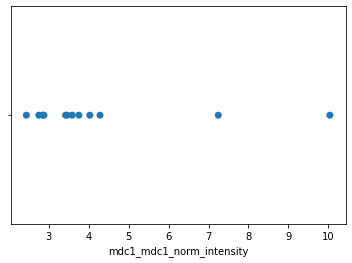

In [9]:
sns.swarmplot(measurement_for_all_fov_df['mdc1_mdc1_norm_intensity'],s=7)

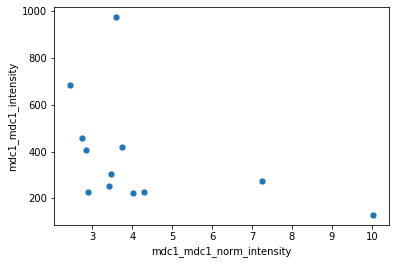

In [10]:
sns.scatterplot(measurement_for_all_fov_df['mdc1_mdc1_norm_intensity'],measurement_for_all_fov_df['mdc1_mdc1_intensity'],s=50)

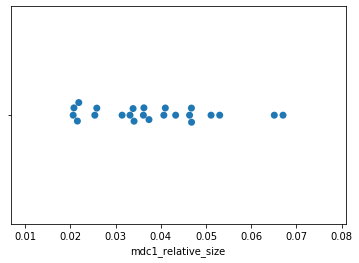

In [28]:
sel_mdc_df = measurement_for_all_fov_df[measurement_for_all_fov_df['mdc1_relative_size']>0]
sns.swarmplot(sel_mdc_df['mdc1_relative_size'],s=7)

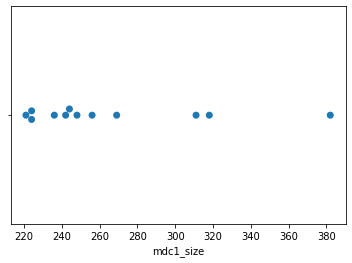

In [11]:
sel_mdc_df = measurement_for_all_fov_df[measurement_for_all_fov_df['mdc1_relative_size']>0]
sns.swarmplot(sel_mdc_df['mdc1_size'],s=7)

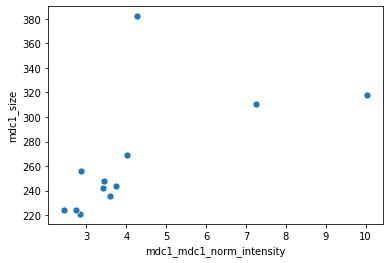

In [12]:
sns.scatterplot(sel_mdc_df['mdc1_mdc1_norm_intensity'],sel_mdc_df['mdc1_size'],s=50)

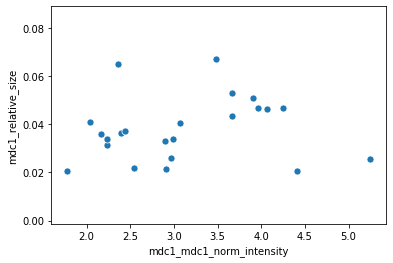

In [36]:
sns.scatterplot(sel_mdc_df['mdc1_mdc1_norm_intensity'],sel_mdc_df['mdc1_relative_size'],s=50)

In [13]:
measurement_for_all_fov_df_filter=measurement_for_all_fov_df[measurement_for_all_fov_df['nucleus_size']>2000]

In [14]:
len(measurement_for_all_fov_df_filter)

6592

In [15]:
len(measurement_for_all_fov_df)

6687

In [16]:
len(sel_mdc_df)

12

In [17]:
len(sel_mdc_df)/len(measurement_for_all_fov_df_filter)

0.0018203883495145632

In [18]:
len(sel_mdc_df)/len(measurement_for_all_fov_df)

0.001794526693584567